In [1]:
from os import path
# import matplotlib.pyplot as plt
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io import json, sbml
from mass.util import qcqa_model
import altair as alt
# from vega_datasets import data
import altair as alt
## lock this version of altair in requirements.txt
import pandas as pd
import numpy as np
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")

started july 2022 

- trying to load differetn models and then combine them

## Making switch bewteen glycolysis and gluconeogenesis 
##### by loading different models at different time points

In [3]:
from mass.io.json import load_json_model

In [4]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
dir = os.path.abspath("")
model_dir = os.path.abspath("models")
minspan_dir= os.path.abspath("minspans_csv")

In [37]:
#  filename="SB2_" + "Glycolysis" + ".json"
model_json = os.path.join(model_dir,"Gly_no_cmpt.json")
glycolysis=load_json_model(model_json)

In [38]:
model_json = os.path.join(model_dir,"Gly_Gluco_no_cmpt.json")
gluconeogenesis=load_json_model(model_json)

Successfully loaded MassModel 'Core_Model' into RoadRunner.


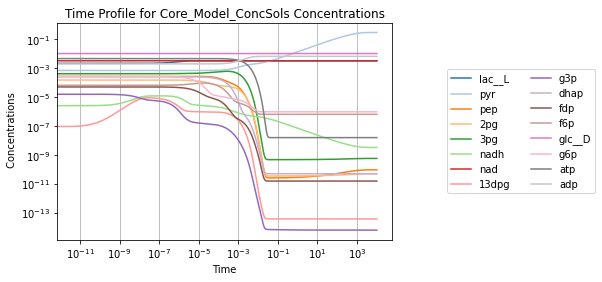

In [39]:
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
# sim.integrator.initial_time_step=1e-6
# sim.integrator.maximum_time_step= 1000
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0,1e4),
                                #  perturbations={"atp_c": 2.5},
                                interpolate=True
                                 )
# Quickly render and display time 
conc_sol.view_time_profile()
conc_sol = conc_sol.to_frame()


Successfully loaded MassModel 'Core_Model' into RoadRunner.


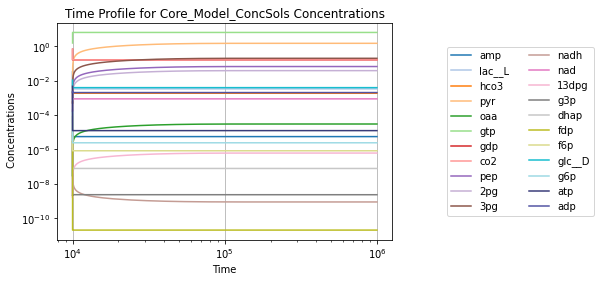

In [40]:
# Setup simulation object
sim = Simulation(gluconeogenesis, verbose=True)
# sim.integrator.initial_time_step=1e-6
# sim.integrator.maximum_time_step= 1000
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol2, flux_sol = sim.simulate(gluconeogenesis, time=(1e4,1e6),
                                #  perturbations={"atp_c": 2.5},
                                  interpolate=True
                                 )
# Quickly render and display time profiles
conc_sol2.view_time_profile()
conc_sol2 = conc_sol2.to_frame()

In [41]:
conc_sol = pd.concat([conc_sol, conc_sol2])

In [42]:
#function to set x label and y label
def set_x_label(xlabel):
    if xlabel==None:
        xlabel="Time"
    else:
        xlabel=xlabel
    return xlabel
        
def set_y_label(ylabel):        
    if ylabel==None:
        ylabel="Concentrations"
    else:
        ylabel=ylabel
    return ylabel


In [43]:
#function to make plot typelinear log
def set_plot_type(plot_type):
    if plot_type == None:
        x_plot_type = 'log'
        y_plot_type = 'log'
    elif plot_type == "logx":
        x_plot_type = 'log'
        y_plot_type = 'linear'
    elif plot_type == "logy":
        x_plot_type = 'linear'
        y_plot_type = 'log'
    elif plot_type == "linear":
        x_plot_type = 'linear'
        y_plot_type = 'linear'
    elif plot_type == "logxlogy":
        x_plot_type = 'log'
        y_plot_type = 'log'
    return x_plot_type,y_plot_type


In [44]:
def view_all_conc_sol(conc_sol,
#                       dynamic=True
                      xlim=None,ylim=None,plot_type=None,xlabel=None,ylabel=None,width=None,height=None):
    """Generate an interactable time profile which can zoom into the plot with interactive tooltip"""
    #Shift click to click multiple
    
    data=conc_sol
    data = data.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')
    
    # Setting X limit and Y limit
    def set_ylim(ylim):
        if ylim == None:
            conc=data['Concentrations']
            ylim_max=max(conc)
            ylim=[1e-5,ylim_max]
        else:
            ylim=ylim
        return ylim
    
    def set_xlim(xlim):
        if xlim == None:
            xlim_max=data['Time'].iloc[-1]
            xlim=[1e-5,xlim_max]

        else:
            xlim=xlim
        return xlim
    xlim=set_xlim(xlim)
    ylim=set_ylim(ylim)
        
       
    # Setting type of plot
    x_plot_type=set_plot_type(plot_type)[0]
    y_plot_type=set_plot_type(plot_type)[1]
        
    # Setting x label and y label
    xlabel=set_x_label(xlabel)
    ylabel=set_y_label(ylabel)
    # Setting width and height
    if width==None:
        width=500
    else:
        width=width
        
    if height==None:
        height=300
    else:
        height=height
    
    alt.data_transformers.disable_max_rows()
    selection = alt.selection_multi(fields=['Metabolites'])
    color = alt.condition(selection,
                          alt.Color('Metabolites:N', legend=None),
                          alt.value('lightgray'))

    line = alt.Chart(data).mark_line(clip=True).encode(alt.X('Time:Q',
                                                             title=xlabel,
                                                             scale=alt.Scale(type = x_plot_type,
                                                                             padding = 10,
                                                                             domain = xlim,
#                   zero=True,
                              ),
              axis=alt.Axis(tickCount=5)),
        alt.Y('Concentrations:Q',
              title=ylabel,
              scale=alt.Scale(type=y_plot_type,
                              padding = 10,
                              domain = ylim,
#                   zero=True, 
                             ),
               axis=alt.Axis(grid=False,
                             tickCount=5)),
        color=color,
        tooltip= ["Metabolites"]+["Time"]+["Concentrations"]
    ).properties(width=width, height=height).interactive()

    
    
#         if dynamic == False:
#             A = alt.layer(line)
#         else:
    legend = alt.Chart(data).mark_point().encode(
        y=alt.Y('Metabolites:N', axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )
    A= line | legend
    return A

In [45]:
view_all_conc_sol(conc_sol,plot_type='logxlogy')

alt.HConcatChart(...)